# Risk Management of FX Options - Risk Ladders

A key control for both risk managers and traders is to understand the value of a portfolio of Options as the market data changes. The notebook looks at 5 different types of report.

- The simplest report to look at is the Spot Ladder. As the name suggests, this risk report captures a series of valuations at different FX Spot rates (the rungs on the ladder). 


- In this section we demonstrate a .1Vol report, where the individual points on the vol surface are bumped seperately to show the risk against each tenor in the surface.


- The next 2 reports look at moving spot and volatility at the same time (as the sensitivity which an option has to spot and volatility is correlated, so the cross risk needs to be understood). In this example, we combine the two reports above to create a report where spot and the pointwise volatility are moved in tandem.

- This report moves the whole volatility surface up or down in value, to look at the sensitivity of the portfolio to the whole surface moving. Again this is combined with spot rate moves to look at the cross effects.

- Finally we show a spot-time report which values the portfolio at different time points, with the spot rate being shifted at each valuation date.


The notebook shows how to create FX Option instruments, book transactions in LUSID and generate and display the risk reports. 

**Table of Contents:**
- [1. Create Portfolio](#1.-Create-Portfolio)
- [2. Create Instrument](#2.-Create-Instrument)
- [3. Upsert Transactions](#3.-Upsert-Transactions)
- [4. Upsert FX Market Data](#4.-Upsert-FX-Market-Data)
- [5. Create Configuration Recipe](#5.-Create-Configuration-Recipe)
- [6. Valuation](#6.-Valuation)
- [7. Spot Ladder](#7.-Spot-Ladder)
- [8. Pointwise Vol Ladder](#8.-Pointwise-Vol-Ladder)
- [9. Spot Pointwise Vol Ladder](#9.-Spot-Pointwise-Vol-Ladder)
- [10. Spot-Vol Ladder](#10.-Spot-Vol-Ladder)
- [11. Spot-Time Ladder](#11.-Spot-Time-Ladder)


In [414]:
# Import generic non-LUSID packages
import os
import pandas as pd
from datetime import datetime, timedelta
import re
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
import json
import pytz
import numpy as np
import copy
from IPython.core.display import HTML

# Import key modules from the LUSID package
import lusid
import lusid.models as lm
import lusid.api as la
from lusid.utilities import ApiClientFactory
from lusidtools.pandas_utils.lusid_pandas import lusid_response_to_data_frame
import utilities.result_tools as restools

# Import key functions from Lusid-Python-Tools and other packages
from lusidjam import RefreshingToken

# Set DataFrame display formats
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.options.display.float_format = "{:,.4f}".format
display(HTML("<style>.container { width:90% !important; }</style>"))

# Set the secrets path
secrets_path = os.getenv("FBN_SECRETS_PATH")

# For running the notebook locally
if secrets_path is None:
    secrets_path = os.path.join(os.path.dirname(os.getcwd()), "secrets.json")

# Authenticate our user and create our API client
api_factory = ApiClientFactory(
    token=RefreshingToken(),
    api_secrets_filename = secrets_path)

print ('LUSID Environment Initialised')
print ('LUSID API Version :', api_factory.build(lusid.api.ApplicationMetadataApi).get_lusid_versions().build_version)

LUSID Environment Initialised
LUSID API Version : 0.6.11471.0


In [415]:
# Set required APIs
portfolio_api = api_factory.build(lusid.api.PortfoliosApi)
transaction_portfolios_api = api_factory.build(lusid.api.TransactionPortfoliosApi)
instruments_api: lusid.InstrumentsApi = api_factory.build(lusid.api.InstrumentsApi)
quotes_api = api_factory.build(lusid.api.QuotesApi)
configuration_recipe_api = api_factory.build(lusid.api.ConfigurationRecipeApi)
complex_market_data_api = api_factory.build(lusid.api.ComplexMarketDataApi)
aggregation_api = api_factory.build(lusid.api.AggregationApi)

In [416]:
# Define scopes
scope = "ibor-optrl"
market_data_scope = "ibor-optrl"
market_supplier = "Lusid"

# 1. Create Portfolio

We begin by creating a portfolio that will contain the FX option instruments that we will be looking to price. We will be grouping the OTC deals using a sub-holding key, this will then keep the transactions associated with a particular deal linked (and not instrument which is the default LUSID behaviour).

In [417]:
# Obtain the LUSID Property Definition API
property_definition_api = api_factory.build(la.PropertyDefinitionsApi)

# Create a property definition for the SHK in the 'Transaction' domain, with a unique scope and code
property_definition = lm.CreatePropertyDefinitionRequest(
    domain = "Transaction",
    scope = scope,
    code = "DealId",
    display_name = "Deal ID",
    data_type_id = lm.ResourceId(
        scope = "system",
        code = "string"
    )
)

# Upsert property definition to LUSID
try:
    upsert_property_definition_response = property_definition_api.create_property_definition(
        create_property_definition_request = property_definition
    )
    print(f"Property definition created with the following key: {upsert_property_definition_response.key}")
except lusid.ApiException as e:
        print(e.body) 

# Capture SHK 3-stage property key for future use
sub_holding_key = f"{property_definition.domain}/{property_definition.scope}/{property_definition.code}"

{"name":"PropertyAlreadyExists","errorDetails":[],"code":124,"type":"https://docs.lusid.com/#section/Error-Codes/124","title":"Error creating Property Definition 'Transaction/ibor-optrl/DealId' because it already exists.","status":400,"detail":"Error creating Property Definition 'Transaction/ibor-optrl/DealId' because it already exists.","instance":"https://calculation.lusid.com/app/insights/logs/0HMRCRLOTQLRK:000000DC","extensions":{}}


In [418]:
portfolio_code = "fxOptionRisk"

try:
    transaction_portfolios_api.create_portfolio(
        scope=scope,
        create_transaction_portfolio_request=lm.CreateTransactionPortfolioRequest(
            display_name=portfolio_code,
            code=portfolio_code,
            base_currency="EUR",
            created="2010-01-01",
            # Register the SHK property with the portfolio
            sub_holding_keys = [sub_holding_key],
            instrument_scopes=[scope]
        ),
    )

except lusid.ApiException as e:
    print(e.body)

{"name":"PortfolioWithIdAlreadyExists","errorDetails":[],"code":112,"type":"https://docs.lusid.com/#section/Error-Codes/112","title":"Could not create a portfolio with id 'fxOptionRisk' because it already exists in scope 'ibor-optrl'.","status":400,"detail":"Error creating portfolio with id 'fxOptionRisk' in scope 'ibor-optrl' effective at 2010-01-01T00:00:00.0000000+00:00 because it already exists.","instance":"https://calculation.lusid.com/app/insights/logs/0HMRCRLOTQLRK:000000DD","extensions":{}}


# 2. Create Instrument

We create a helper function to create and upsert the fxOption instrument into LUSID, this will reference the SDK models to populate the required parameters for creating an FX Option. We then populate the instrument variables, and make a call to persist the instrument in LUSID.

In [419]:
# Define functions that creates and upserts an FX option
def create_fx_option(strike, dom_ccy, fgn_ccy, start_date, maturity_date, settlement_date, is_call, is_fx_delivery = True, is_payoff_digital = False, exercise_type = "European"):
    
    return lm.FxOption(
        strike = strike,
        dom_ccy = dom_ccy,
        fgn_ccy = fgn_ccy,
        start_date = start_date,
        option_maturity_date = maturity_date,
        option_settlement_date = settlement_date,
        is_call_not_put = is_call,
        is_delivery_not_cash = is_fx_delivery,
        is_payoff_digital = is_payoff_digital,
        instrument_type = "FxOption",
        dom_amount = 1,
        exercise_type = exercise_type
    )

# Define a function to upsert instrument
def upsert_instrument_to_lusid(scope, instrument_definition, name, identifier, identifier_type):
        return instruments_api.upsert_instruments(
            request_body={
                identifier: lm.InstrumentDefinition(
                    name=name,
                    identifiers={
                        identifier_type: lm.InstrumentIdValue(value=identifier)
                    },
                    definition=instrument_definition,
                )
            },
            scope = scope
        )

## 2.1 Create Instruments

All the informaton about the 2 FXOptions are contained in the next 2 cells, including the pricing model so that all of this data is together.

Change this data as you see fit to understand how the different Option types work in LUSID. The table below shows the different model and PayOff Combinations

![Init](img/FXOptionSummary.PNG)

For this workbook, the valuations are set up at portfolio level, as such the options must use the same valuation model

In [420]:
# Set common  trade variables
trade_date = datetime(2021, 1, 20, tzinfo=pytz.utc)
start_date = trade_date
settle_days = 2
units = 1000000
dom_ccy = "EUR"
fgn_ccy = "USD"
premium_currency = "EUR"
identifier_type = "ClientInternal"
valuation_model = "BlackScholes"

# Option_1:
maturity_date = trade_date + timedelta(days = 70)
settlement_date = maturity_date + timedelta(days = 2)

strike = 1.2050
option_1_name = "EUR/USD FX Option " + maturity_date.strftime("%m/%d/%Y")  + " " + str(strike)
option_1_identifier = "EURUSDOption1DemoRisk"

# Create the Instrument
option_1_definition = create_fx_option(
    strike = strike,
    dom_ccy = dom_ccy,
    fgn_ccy = fgn_ccy,
    start_date = start_date,
    maturity_date = maturity_date,
    settlement_date = settlement_date,
    is_call = True,
    is_fx_delivery = True,
    is_payoff_digital = False,
    exercise_type = "European"
)

# Upsert the instrument
upsert_response = upsert_instrument_to_lusid(scope, option_1_definition, option_1_name, option_1_identifier, identifier_type)
luid = upsert_response.values[option_1_identifier].lusid_instrument_id
print(f"{luid} : {option_1_identifier}")

LUID_000049JK : EURUSDOption1DemoRisk


In [421]:
#Option_2:
maturity_date = trade_date + timedelta(days = 400)
settlement_date = maturity_date + timedelta(days = 2)

strike = 1.19
option_2_name = "EUR/USD FX Option " + maturity_date.strftime("%m/%d/%Y")  + " " + str(strike)
option_2_identifier = "EURUSDOption2DemoRisk"

# Create the Instrument
option_2_definition = create_fx_option(
    strike = strike,
    dom_ccy = dom_ccy,
    fgn_ccy = fgn_ccy,
    start_date = start_date,
    maturity_date = maturity_date,
    settlement_date = settlement_date,
    is_call = False,
    is_fx_delivery = False,
    is_payoff_digital = False,
    exercise_type = "European"
)

# Upsert the instrument
upsert_response = upsert_instrument_to_lusid(scope, option_2_definition, option_2_name, option_2_identifier, identifier_type)
luid = upsert_response.values[option_2_identifier].lusid_instrument_id
print(f"{luid} : {option_2_identifier}")

LUID_000049JL : EURUSDOption2DemoRisk


# 3. Upsert Transactions

Having created the portfolio and the Instruments, we add a Buy transaction against the option to create a position with the costs incurred representing the premium for the option.

In [422]:
# Book a Buy transaction against Option_1. The option here has a premium of 0.02 / notional.
premium = 0.02
option_1_version = 1
deal_1_id = "TXN001"

opt_txn = lm.TransactionRequest(
    transaction_id= deal_1_id + "." + str(option_1_version),
    type="Buy",
    instrument_identifiers={"Instrument/default/ClientInternal": option_1_identifier},
    transaction_date=trade_date.isoformat(),
    settlement_date=(trade_date + timedelta(days = settle_days)).isoformat(),
    units=units,
    transaction_price=lm.TransactionPrice(price=premium,type="Price"),
    total_consideration=lm.CurrencyAndAmount(amount=premium*units,currency=premium_currency),
    exchange_rate=1,
    transaction_currency=premium_currency,
    # Assign the SHK property to each transaction so it is loaded against each deal_id
    properties = {
        f"{sub_holding_key}": lm.PerpetualProperty(
            key = f"{sub_holding_key}",
            value = lm.PropertyValue(label_value = deal_1_id)
        )
    },
)

response = transaction_portfolios_api.upsert_transactions(scope=scope,
                                                    code=portfolio_code,
                                                    transaction_request=[opt_txn])

print(f"Transaction successfully updated at time: {response.version.as_at_date}")

option_1_version = option_1_version + 1

Transaction successfully updated at time: 2022-11-03 10:38:35.204928+00:00


In [423]:
# Book a Sell transaction against Option_1. The option here has a premium of 0.03 / notional (the premium will be greater for this option as it has a longer duration to expiry)
premium = 0.03
option_2_version = 1
deal_2_id = "TXN002"

opt_txn = lm.TransactionRequest(
    transaction_id= deal_2_id + "." + str(option_2_version),
    type="Sell",
    instrument_identifiers={"Instrument/default/ClientInternal": option_2_identifier},
    transaction_date=trade_date.isoformat(),
    settlement_date=(trade_date + timedelta(days = settle_days)).isoformat(),
    units=units,
    transaction_price=lm.TransactionPrice(price=premium,type="Price"),
    total_consideration=lm.CurrencyAndAmount(amount=premium*units,currency=premium_currency),
    exchange_rate=1,
    transaction_currency=premium_currency,
    # Assign the SHK property to each transaction so it is loaded against each deal_id
    properties = {
        f"{sub_holding_key}": lm.PerpetualProperty(
            key = f"{sub_holding_key}",
            value = lm.PropertyValue(label_value = deal_2_id)
        )
    },
)

response = transaction_portfolios_api.upsert_transactions(scope=scope,
                                                    code=portfolio_code,
                                                    transaction_request=[opt_txn])

print(f"Transaction successfully updated at time: {response.version.as_at_date}")
option_2_version = option_2_version + 1

Transaction successfully updated at time: 2022-11-03 10:38:35.204928+00:00


# 4. Upsert FX Market Data

Next we will be loading the required marked data into the quotes store. In this particular example to value an option, we will be using the standard Black-Scholes pricing model. This model requires the following data:
1. EUR/USD Spot Rates - this is the value of the underlying of the option
2. EUR and USD discount curves - these curves are required for 2 things: to calculate the implied fx forward rate; and as the option is expiring and maturing in the future, to discount future cash flows
3. EURUSD volatility surface - the value of an option is closely related to the expected volatility of the underlying over the period of the option

## 4.1 FX Spot Rates

We begin by adding the FX spot rates.

In [424]:
# Read fx spot rates and make datetimes timezone aware
quotes_df = pd.read_csv("data/eurusd_spot.csv")
quotes_df["Date"] = pd.to_datetime(quotes_df["Date"], dayfirst=True)
quotes_df["Date"] = quotes_df["Date"].apply(lambda x: x.replace(tzinfo=pytz.utc))
quotes_df.head()

,Date,Rate,Pair
0,2021-01-01 00:00:00+00:00,1.2215,EUR/USD
1,2021-01-04 00:00:00+00:00,1.2248,EUR/USD
2,2021-01-05 00:00:00+00:00,1.2298,EUR/USD
3,2021-01-06 00:00:00+00:00,1.2327,EUR/USD
4,2021-01-07 00:00:00+00:00,1.2272,EUR/USD


In [425]:
# Create quotes request
instrument_quotes = {
            index: lm.UpsertQuoteRequest(
            quote_id=lm.QuoteId(
                quote_series_id=lm.QuoteSeriesId(
                    provider=market_supplier,
                    instrument_id=row["Pair"],
                    instrument_id_type="CurrencyPair",
                    quote_type="Rate",
                    field="mid",
                ),
                effective_at=row["Date"].isoformat(),
            ),
            metric_value=lm.MetricValue(value=row["Rate"], unit=row["Pair"]),
        )
    for index, row in quotes_df.iterrows()
}

# Upsert quotes into LUSID
response = quotes_api.upsert_quotes(
    scope=market_data_scope, request_body=instrument_quotes
)

if response.failed == {}:
    print(f"Quotes successfully loaded into LUSID. {len(response.values)} quotes loaded.")
else:
    print(f"Some failures occurred during quotes upsertion, {len(response.failed)} did not get loaded into LUSID.")

Quotes successfully loaded into LUSID. 223 quotes loaded.


## 4.2 EUR & USD Discount curves

Next we will read in the EUR and USD Discount factors and create separate OIS curves.

In [426]:
# Read FX market data - showing first 10 terms
df_market_data = pd.read_csv("data/EURUSD-MarketData.csv")
df_market_data["Days"]= df_market_data["Days"].astype(int)
df_market_data = df_market_data.reset_index()
df_market_data.head(10)

,index,Tenor,Days,EUR-Rates,USD-Rates,EURdf,USDdf,Vol25D,ATM,Vol75D,Strike25D,StrikeATM,Strike75D
0,0,1M,30,0.2200,1.2200,0.9998,0.9990,0.1200,0.1000,0.1100,1.1850,1.2000,1.2150
1,1,2M,60,0.3700,1.3700,0.9994,0.9978,0.1205,0.1010,0.1105,1.1850,1.2000,1.2150
2,2,3M,90,0.5300,1.5300,0.9987,0.9962,0.1210,0.1020,0.1110,1.1850,1.2000,1.2150
3,3,6M,180,0.9500,1.9500,0.9953,0.9904,0.1215,0.1030,0.1115,1.1850,1.2000,1.2150
4,4,1Y,365,1.3000,2.3000,0.9871,0.9773,0.1220,0.1040,0.1120,1.1850,1.2000,1.2150
5,5,18M,547,1.5000,2.5000,0.9778,0.9632,0.1225,0.1050,0.1125,1.1850,1.2000,1.2150
6,6,2Y,730,1.5000,2.5000,0.9705,0.9513,0.1230,0.1060,0.1130,1.1850,1.2000,1.2150
7,7,3Y,1095,1.4300,2.4300,0.9580,0.9297,0.1235,0.1070,0.1135,1.1850,1.2000,1.2150
8,8,4Y,1460,1.3700,2.3700,0.9467,0.9096,0.1240,0.1080,0.1140,1.1850,1.2000,1.2150
9,9,5Y,1825,1.3100,2.3100,0.9366,0.8909,0.1245,0.1090,0.1145,1.1850,1.2000,1.2150


In [427]:
def create_artificial_yieldcurve(curve: lm.DiscountFactorCurveData, ccy: str):

    # r1 = (settlement - base_date).days
    # rate = fra(r1)

    # Then
    # t1 = (settlement - base_date).days / 365
    # t2 = (maturity - base_date).days / 365
    # t12 = (maturity - settlement).days / 365
    # rate = ((1 + r1 * t1) * (1 + t12 * rate_quote) - 1) / t2;

    # Assume that t2 = t2 => t12 = 0
    # rate = r1

    # df = 1 / (1 + t * rate) => rate = ((1 / df) - 1) / t
    # where t is time in days

    def rate_from_df(df: float, t: float):
        return ((1 / df) - 1) / t

    def create_artificial_fra(base_date: datetime, maturity: datetime, ccy: str, discount_factor: float) -> lm.ForwardRateAgreement:

        rate = rate_from_df(discount_factor, (maturity - base_date).days / 365.0)
        return lm.ForwardRateAgreement(
            start_date = base_date,
            maturity_date = maturity, 
            dom_ccy = ccy,
            fixing_date = maturity, 
            fra_rate = rate,
            notional = 1,
            instrument_type=lm.InstrumentType.FORWARDRATEAGREEMENT
        )
    pair = list(zip(curve.dates, curve.discount_factors))

    def quote_from_value(value: float):
        return lm.MarketQuote(lm.QuoteType.RATE, value)

    return lm.YieldCurveData(
        curve.base_date,
        instruments = [create_artificial_fra(curve.base_date, maturity, ccy, df) for (maturity, df) in pair],
        quotes = [quote_from_value(rate_from_df(df, (maturity - curve.base_date).days / 365.0)) for (maturity, df) in pair],
        market_data_type = lm.MarketDataType.YIELDCURVEDATA
    )

In [428]:
# Set up the OIS curves loader function
def upsert_discount_factors(scope, effective_at, market_asset: str, dates, dfs):

    df_curve = lm.DiscountFactorCurveData(
        base_date=effective_at,
        dates=dates,
        discount_factors = dfs,
        market_data_type="DiscountFactorCurveData"
    )
    complex_market_data = create_artificial_yieldcurve(df_curve, market_asset.split("/")[0])

    # create a unique identifier for our OIS yield curves
    complex_id = lm.ComplexMarketDataId(
        provider=market_supplier,
        price_source = market_supplier,
        effective_at=effective_at.isoformat(),
        market_asset=market_asset,
    )
    
    upsert_request = lm.UpsertComplexMarketDataRequest(
        market_data_id=complex_id, market_data=complex_market_data
    )


    response = complex_market_data_api.upsert_complex_market_data(
        scope=scope, request_body={market_asset: upsert_request}
    )
    
    if response.failed:
        print(f"Failed to upload yield curve {response.failed}")

    print(f"{market_asset} yield curve uploaded into scope={scope}")
    
    return complex_id

In [429]:
# Set up the OIS curves
base_date = trade_date
dates = []
EUR_dfs = []
USD_dfs = []

# loading the data for EUR OIS discount curve
for index, row in df_market_data.iterrows():
    dates.append(base_date + timedelta(days=row["Days"]))
    EUR_dfs.append(row["EURdf"])
    USD_dfs.append(row["USDdf"])

curve_id_EUR = upsert_discount_factors(market_data_scope, base_date, "EUR/EUROIS", dates, EUR_dfs)
curve_id_USD = upsert_discount_factors(market_data_scope, base_date, "USD/USDOIS", dates, USD_dfs)

EUR/EUROIS yield curve uploaded into scope=ibor-optrl
USD/USDOIS yield curve uploaded into scope=ibor-optrl


We can also use the _ComplexMarketDataApi_ to retrieve the data as it's been stored in LUSID. See below for the returned object, and a plot showing both OIS discount curves.

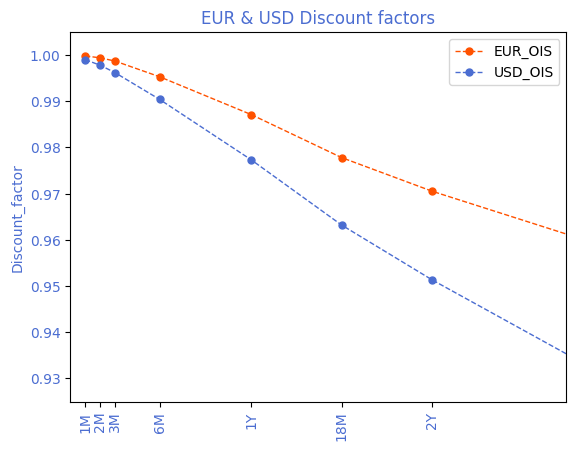

In [430]:
# Retrieve the two curves from LUSID to demonstrate graphically the data we have laoded
EUR_OIS_curve = complex_market_data_api.get_complex_market_data(
    scope=market_data_scope,
    effective_at = curve_id_EUR.effective_at,
    request_body= {"1": curve_id_EUR}
)

USD_OIS_curve = complex_market_data_api.get_complex_market_data(
    scope=market_data_scope,
    effective_at = curve_id_USD.effective_at,
    request_body= {"1": curve_id_USD}
)

def get_discount_factor(curve: lm.YieldCurveData) -> list[float]:
    instruments: list[lm.ForwardRateAgreement] = curve.instruments
    return [1 / (1 + x.fra_rate * (x.maturity_date - x.start_date).days / 365.0) for x in instruments]

# Get axis data and create plot
plt.plot(df_market_data["Days"], get_discount_factor(EUR_OIS_curve.values["1"]), color='#ff5200' , marker='o', markersize=5, linestyle='--', linewidth=1, label="EUR_OIS")
plt.plot(df_market_data["Days"],get_discount_factor(USD_OIS_curve.values["1"]), color='#4b6dd1' , marker='o', markersize=5, linestyle='--', linewidth=1, label="USD_OIS")
plt.yticks( color = '#4b6dd1')
plt.xticks(df_market_data["Days"], df_market_data["Tenor"], rotation='vertical', color = '#4b6dd1')
plt.title('EUR & USD Discount factors', color = '#4b6dd1')
plt.ylabel('Discount_factor', color = '#4b6dd1')
plt.xlim([0, 1000]), plt.ylim([.925, 1.005])
plt.legend(loc="upper right")
plt.show()

## 4.3 FX Volatility Surface
Next we will read in our FX Vol surface data, and need to create a set of vanilla option instruments representing the FX Option for each tenor in the market data. The volatility curve is constructed using a set of liquid market instruments for vanilla options with different expiry dates, all with a start date of the current date (in this workbook the base_date). Traders would observe option premium prices in the market, and determine the volatility (by solving using the Black-Scholes formula) to allow the volatility curve to be created. Ordinarily a volatility surface is created with a number (usually 3 or 5) of different in and out of the money options being used at each expiry date, with a 'Smile Model' used to interpolate between these points. LUSID provides a more basic interpolation between the data points currently.

To set up a Vol curve you need to abide by the following constraints in LUSID:
1. The vol surface needs to have at least 2 different strikes at each tenor, these strikes must be consistent across all tenors
2. An instrument representing the vanilla fx option needs to be created for each tenor / strike combination
3. Quotes need to be loaded for all tenor / strike combinations

Below I demonstrate setting up a simple 3 point smile in LUSID - before loading this data into LUSID, lets visualise the data we are loading.

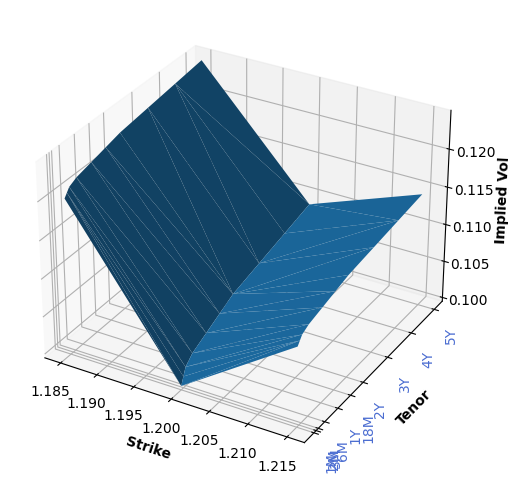

In [431]:
Xs = []
Ys = []
Zs = []

for index, row in df_market_data.iterrows():
    Xs.append(row["Strike25D"])
    Ys.append(row["Days"])
    Zs.append(row["Vol25D"])
    
for index, row in df_market_data.iterrows():
    Xs.append(row["StrikeATM"])
    Ys.append(row["Days"])
    Zs.append(row["ATM"])
    
for index, row in df_market_data.iterrows():
    Xs.append(row["Strike75D"])
    Ys.append(row["Days"])
    Zs.append(row["Vol75D"])
    
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('Strike', fontweight ='bold')
ax.set_ylabel('Tenor', fontweight ='bold')
ax.set_zlabel('Implied Vol', fontweight ='bold')
surf = ax.plot_trisurf(Xs, Ys, Zs, linewidth=0.1)
plt.yticks(df_market_data["Days"], df_market_data["Tenor"], rotation='vertical', color = '#4b6dd1')
plt.show()

### 4.3.1 Create the curve instruments

In this section we create and upsert the curve instruments used in the volatility curve.

In [432]:
def upsert_fxoption_curve_instruments (df_vol_data, vol_point_type):

    for index, row in df_vol_data.iterrows():

        option_expiry = base_date + timedelta(days=row["Days"])

        # Create the Instrument
        option_definition = create_fx_option(
            strike = row["Strike"],
            dom_ccy = dom_ccy,
            fgn_ccy = fgn_ccy,
            start_date = base_date,
            maturity_date = option_expiry,
            settlement_date =option_expiry + timedelta(days=2),
            is_call = True,
            is_payoff_digital = False,
            is_fx_delivery = True,
        )

        option_name = "EUR/USD " + " FX Option " + option_expiry.strftime("%m/%d/%Y")
        option_identifier = (f"EURUSDVolCurve-{index}-{row['Tenor']}-{vol_point_type}")

        curve_identifiers.append(option_identifier)
        curve_instruments.append(option_definition)

        # Upsert the instrument
        upsert_response = upsert_instrument_to_lusid(scope, option_definition, option_name, option_identifier, identifier_type)

In [433]:
curve_instruments = []
curve_identifiers = []

upsert_fxoption_curve_instruments (df_market_data[["Tenor", "Days", "Strike25D"]].rename(columns={"Strike25D" : "Strike"}), "25D")
upsert_fxoption_curve_instruments (df_market_data[["Tenor", "Days", "StrikeATM"]].rename(columns={"StrikeATM" : "Strike"}), "ATM")
upsert_fxoption_curve_instruments (df_market_data[["Tenor", "Days", "Strike75D"]].rename(columns={"Strike75D" : "Strike"}), "75D")

print(f"{len(curve_instruments)} instruments uploaded to create the vol curve")

30 instruments uploaded to create the vol curve


### 4.3.2 Upload Volatility surface

Next we create the volatility surface in LUSID, associating volatility quotes with each of the instruments we have loaded

In [434]:
# Function to load the surface into Lusid
def upsert_fx_vol(scope, effective_at, market_asset, instruments, vols_low_strike, vols_atm, vols_high_strike):

    market_data_id = lm.ComplexMarketDataId(
        provider=market_supplier,
        price_source="Lusid",
        effective_at=effective_at,
        market_asset=market_asset,
    )
    
    quotes = []
    
    for vol in vols_low_strike:
        quotes.append(lm.MarketQuote(quote_type="LogNormalVol", value=vol))
        
    for vol in vols_atm:
        quotes.append(lm.MarketQuote(quote_type="LogNormalVol", value=vol))   
                
    for vol in vols_high_strike:
        quotes.append(lm.MarketQuote(quote_type="LogNormalVol", value=vol))   

    fx_vol_surface_data = lm.FxVolSurfaceData(
        base_date=effective_at,
        instruments=instruments,
        quotes=quotes,
        market_data_type="FxVolSurfaceData"
    )  
    
    response = complex_market_data_api.upsert_complex_market_data(
        scope=scope,
        request_body={
            market_asset: lm.UpsertComplexMarketDataRequest(
                market_data_id=market_data_id, market_data=fx_vol_surface_data
            )
        },
    )
    
    if len(response.failed) == 0:
        print(f"Quote successfully loaded into LUSID. {len(response.values)} quotes loaded.")

    else:
        print(f"Some failures occurred during quotes upsertion, {len(response.failed)} did not get loaded into LUSID.")
        
    return market_data_id

In [435]:
# Actual load of the data into LUSID
EURUSD_vol_curve_id = upsert_fx_vol(market_data_scope, base_date, "EUR/USD/LN", curve_instruments, df_market_data["Vol25D"], df_market_data["ATM"], df_market_data["Vol75D"])

Quote successfully loaded into LUSID. 1 quotes loaded.


# 5. Create Configuration Recipe

In order to run a valuation, LUSID will require a recipe that drives how a valuation will be conducted. The below recipe defines what model and market data to use in this context.


In [436]:
# Set recipe code
recipe_code = "OptValuation"

# Populate recipe parameters
configuration_recipe = lm.ConfigurationRecipe(
    scope=market_data_scope,
    code=recipe_code,
    market=lm.MarketContext(
        market_rules=[
            lm.MarketDataKeyRule(
                    key="FX.CurrencyPair.*",
                    supplier=market_supplier,
                    data_scope=market_data_scope,
                    quote_type="Rate",
                    field="mid",
                    quote_interval="100D"
                ),
            lm.MarketDataKeyRule(
                key="FXVol.*.*.*",
                supplier=market_supplier,
                data_scope=market_data_scope,
                price_source=market_supplier,
                quote_type="Price",
                field="mid",
                quote_interval="100D",
            ),
            lm.MarketDataKeyRule(
                key="Rates.*.*",
                supplier=market_supplier,
                data_scope=market_data_scope,
                price_source=market_supplier,
                quote_type="Price",
                field="mid",
                quote_interval="100D",
            ),
        ],
        options=lm.MarketOptions(
            default_scope = market_data_scope,
            attempt_to_infer_missing_fx=True
        ),
    ),
    pricing=lm.PricingContext(
        model_rules=[
            lm.VendorModelRule(
                supplier="Lusid",
                model_name=valuation_model,
                instrument_type="FXOption",
                parameters="{}",
            )
        ],
        options = lm.PricingOptions(
            allow_partially_successful_evaluation = True
        )
    ),
)

response = configuration_recipe_api.upsert_configuration_recipe(
    upsert_recipe_request=lm.UpsertRecipeRequest(
        configuration_recipe=configuration_recipe
    )
)


print(f"Configuration recipe loaded into LUSID at time {response.value}.")

Configuration recipe loaded into LUSID at time 2023-06-14 15:01:43.401144+00:00.


# 6. Valuation

Value the portfolio using the Black Scholes model

In [437]:
def get_all_risk_keys() -> list[lusid.AggregationQuery]:
    """
    Get all queryable keys within Risk domain
    """
    return [x for x in aggregation_api.get_queryable_keys().values if x.address_key.startswith("Risk/")]

def run_valuation(date: datetime | list[datetime], portfolio_code: str, group_by_portfolio: bool = False, additional_keys: list[lm.AggregateSpec] = []):
    
    metrics = [
        lm.AggregateSpec("Valuation/EffectiveAt", "Value"),
        lm.AggregateSpec("Instrument/default/Name", "Value"),
        lm.AggregateSpec("Quotes/FxRate/DomFgn", "Value"),
        lm.AggregateSpec("Instrument/default/ClientInternal", "Value"),
        lm.AggregateSpec("Transaction/Id", "Value"),
        lm.AggregateSpec("Holding/Units", "Value"),
        lm.AggregateSpec("Valuation/PvInPortfolioCcy", "Value"),
        lm.AggregateSpec("Valuation/Delta", "Value"),  
        lm.AggregateSpec("Portfolio/default/Name", "Value"),
    ] + additional_keys

    group_by = []
    if group_by_portfolio:
        group_by = ['Valuation/EffectiveAt', 'Portfolio/default/Name']
        metrics = [
            lm.AggregateSpec("Valuation/EffectiveAt", "Value"), # ValuationDate
            lm.AggregateSpec("Quotes/FxRate/DomFgn", "Value"), # SpotRate
            lm.AggregateSpec("Valuation/PvInPortfolioCcy", "Sum"),
            lm.AggregateSpec("Valuation/Delta", "Value"),  
            lm.AggregateSpec("Portfolio/default/Name", "Value"),  
        ] + additional_keys

    schedule = [x.isoformat() for x in date] if type(date) is list else [date.isoformat()]

    valuation_request = lm.ValuationRequest(
        recipe_id=lm.ResourceId(scope=market_data_scope, code=recipe_code),
        metrics=metrics,
        group_by=group_by,
        portfolio_entity_ids=[
            lm.PortfolioEntityId(scope=scope, code=portfolio_code)
        ],
        valuation_schedule=lm.ValuationSchedule(
            effective_at=min(schedule),
            valuation_date_times=schedule
            # effective_at = date.isoformat(),
        ),
    )

    val_data = aggregation_api.get_valuation(valuation_request=valuation_request).data
    
    return pd.DataFrame(val_data)

In [438]:
def post_process(df: pd.DataFrame, rename_columns: bool = True, drop_empty: bool = True):
    if rename_columns:
        df.rename(
            columns={
                "Valuation/EffectiveAt" : "ValuationDate",
                "Instrument/default/Name" : "InstrumentName",
                "Instrument/default/ClientInternal" : "ClientInternal",
                "Valuation/PvInPortfolioCcy": "Present Value",
                "Sum(Valuation/PvInPortfolioCcy)": "Sum(Present Value)",
                "Holding/Units" : "Holding",
                "Valuation/Delta" : "Delta",
                "Portfolio/default/Name" : "Portfolio"
            },
            inplace=True,
        )
    if "Valuation/Risk/SpotDelta" in df.columns:
        df.drop(columns=["Valuation/Risk/SpotDelta"], inplace=True)
    # drop columns where every entry is none
    if drop_empty:
        df.dropna(axis = 1, how='all', inplace=True)

    # drop rows that are built-in instruments (these won't have ClientInternal id). eg.: currencies
    if "ClientInternal" in df.columns:
        df.dropna(subset=["ClientInternal"], inplace=True)

    # convert ValuationDate column to datetime
    df["ValuationDate"] = pd.to_datetime(df["ValuationDate"])
    
    return df

In [501]:
print("\n".join([x.address_key for x in get_all_risk_keys()]))

Risk/Equity/Delta/Forward/Parallel
Risk/Equity/Delta/Backward/Parallel
Risk/Equity/Delta/Central/Parallel
Risk/Equity/Gamma/Parallel
Risk/Equity/Delta/Forward/PointWise
Risk/Equity/Delta/Backward/PointWise
Risk/Equity/Delta/Central/PointWise
Risk/Equity/Gamma/PointWise
Risk/Equity/Difference/Ladder
Risk/FxVol/Delta/Forward/Parallel
Risk/FxVol/Delta/Backward/Parallel
Risk/FxVol/Delta/Central/Parallel
Risk/FxVol/Gamma/Parallel
Risk/FxVol/Delta/Forward/PointWise
Risk/FxVol/Delta/Backward/PointWise
Risk/FxVol/Delta/Central/PointWise
Risk/FxVol/Gamma/PointWise
Risk/FxVol/Difference/Ladder
Risk/IrVol/Delta/Forward/Parallel
Risk/IrVol/Delta/Backward/Parallel
Risk/IrVol/Delta/Central/Parallel
Risk/IrVol/Gamma/Parallel
Risk/IrVol/Delta/Forward/PointWise
Risk/IrVol/Delta/Backward/PointWise
Risk/IrVol/Delta/Central/PointWise
Risk/IrVol/Gamma/PointWise
Risk/IrVol/Difference/Ladder
Risk/Fx/Delta/Forward/Parallel
Risk/Fx/Delta/Backward/Parallel
Risk/Fx/Delta/Central/Parallel
Risk/Fx/Gamma/Parallel
R

In [439]:
pd.set_option('display.max_colwidth', 200)
valuation = post_process(run_valuation(base_date, portfolio_code, additional_keys=[lm.AggregateSpec(x.address_key, "Value") for x in get_all_risk_keys()]))
display(valuation)

,ValuationDate,InstrumentName,Quotes/FxRate/DomFgn,ClientInternal,Transaction/Id,Holding,Present Value,Delta,Portfolio,Risk/FxVol/Delta/Forward/Parallel,Risk/FxVol/Delta/Backward/Parallel,Risk/FxVol/Delta/Central/Parallel,Risk/FxVol/Gamma/Parallel,Risk/FxVol/Delta/Forward/PointWise,Risk/FxVol/Delta/Backward/PointWise,Risk/FxVol/Delta/Central/PointWise,Risk/FxVol/Gamma/PointWise,Risk/FxVol/Difference/Ladder,Risk/Fx/Delta/Forward/Parallel,Risk/Fx/Delta/Backward/Parallel,Risk/Fx/Delta/Central/Parallel,Risk/Fx/Gamma/Parallel,Risk/Fx/Delta/Forward/PointWise,Risk/Fx/Delta/Backward/PointWise,Risk/Fx/Delta/Central/PointWise,Risk/Fx/Gamma/PointWise,Risk/Fx/Difference/Ladder,Risk/Rates/Delta/Forward/Parallel,Risk/Rates/Delta/Backward/Parallel,Risk/Rates/Delta/Central/Parallel,Risk/Rates/Gamma/Parallel,Risk/Rates/Delta/Forward/PointWise,Risk/Rates/Delta/Backward/PointWise,Risk/Rates/Delta/Central/PointWise,Risk/Rates/Gamma/PointWise,Risk/Rates/Difference/Ladder,Risk/Fx/Parallel/FxVol/Parallel/Dy/Dx,Risk/Fx/Ladder/Rates/Ladder/Difference
0,2021-01-20 00:00:00+00:00,EUR/USD FX Option 03/31/2021 1.205,1.2106,EURUSDOption1DemoRisk,None,"1,000,000.0000","21,609.7001",0.5643,fxOptionRisk,"{'FxVol:EUR.USD.LN': {'resultValueType': 'Result0D', 'dimension': 0, 'hasAnnotation': False, 'units': {'units': []}, 'values': {'(0,0)': 0.0}}}","{'FxVol:EUR.USD.LN': {'resultValueType': 'Result0D', 'dimension': 0, 'hasAnnotation': False, 'units': {'units': []}, 'values': {'(0,0)': 0.0}}}","{'FxVol:EUR.USD.LN': {'resultValueType': 'Result0D', 'dimension': 0, 'hasAnnotation': False, 'units': {'units': []}, 'values': {'(0,0)': 0.0}}}","{'FxVol:EUR.USD.LN': {'resultValueType': 'Result0D', 'dimension': 0, 'hasAnnotation': False, 'units': {'units': []}, 'values': {'(0,0)': 0.0}}}","{'FxVol:EUR.USD.LN': {'resultValueType': 'Result2D', 'labelsY': {'FXO;EURUSD;20210219': 0, 'FXO;EURUSD;20210321': 1, 'FXO;EURUSD;20210420': 2, 'FXO;EURUSD;20210719': 3, 'FXO;EURUSD;20220120': 4, '...","{'FxVol:EUR.USD.LN': {'resultValueType': 'Result2D', 'labelsY': {'FXO;EURUSD;20210219': 0, 'FXO;EURUSD;20210321': 1, 'FXO;EURUSD;20210420': 2, 'FXO;EURUSD;20210719': 3, 'FXO;EURUSD;20220120': 4, '...","{'FxVol:EUR.USD.LN': {'resultValueType': 'Result2D', 'labelsY': {'FXO;EURUSD;20210219': 0, 'FXO;EURUSD;20210321': 1, 'FXO;EURUSD;20210420': 2, 'FXO;EURUSD;20210719': 3, 'FXO;EURUSD;20220120': 4, '...","{'FxVol:EUR.USD.LN': {'resultValueType': 'Result2D', 'labelsY': {'FXO;EURUSD;20210219': 0, 'FXO;EURUSD;20210321': 1, 'FXO;EURUSD;20210420': 2, 'FXO;EURUSD;20210719': 3, 'FXO;EURUSD;20220120': 4, '...","{'FxVol:EUR.USD.LN': {'resultValueType': 'Result1D', 'labelsY': {'-0.05': 0, '-0.025': 1, '-0.01': 2, '-0.005': 3, '0.0': 4, '0.005': 5, '0.01': 6, '0.025': 7, '0.05': 8}, 'dimension': 1, 'hasAnno...","{'Fx:EUR.USD': {'resultValueType': 'Result0D', 'dimension': 0, 'hasAnnotation': False, 'units': {'units': []}, 'values': {'(0,0)': -65.7617105353}}}","{'Fx:EUR.USD': {'resultValueType': 'Result0D', 'dimension': 0, 'hasAnnotation': False, 'units': {'units': []}, 'values': {'(0,0)': -65.8876936709}}}","{'Fx:EUR.USD': {'resultValueType': 'Result0D', 'dimension': 0, 'hasAnnotation': False, 'units': {'units': []}, 'values': {'(0,0)': -65.8247021031}}}","{'Fx:EUR.USD': {'resultValueType': 'Result0D', 'dimension': 0, 'hasAnnotation': False, 'units': {'units': []}, 'values': {'(0,0)': 0.1259831356}}}","{'Fx:EUR.USD': {'resultValueType': 'Result1D', 'labelsY': {'USD': 1, 'EUR': 2}, 'dimension': 1, 'hasAnnotation': False, 'units': {'units': []}, 'values': {'(0,0)': -65.7617105353, '(1,0)': -65.761...","{'Fx:EUR.USD': {'resultValueType': 'Result1D', 'labelsY': {'USD': 1, 'EUR': 2}, 'dimension': 1, 'hasAnnotation': False, 'units': {'units': []}, 'values': {'(0,0)': -65.8876936709, '(1,0)': -65.887...","{'Fx:EUR.USD': {'resultValueType': 'Result1D', 'labelsY': {'USD': 1, 'EUR': 2}, 'dimension': 1, 'hasAnnotation': False, 'units': {'units': []}, 'values': {'(0,0)': -65.8247021031, '(1,0)': -65.824...","{'Fx:EU

The above output shows the valuations for the 2 options, and the 2 settled premium cashflows in EUR. Each of the columns are explained below:

- Holding: This is the notional of the fxoption (in this example the fxoptions are represented as unit instruments to allow aggregation of individual trades in the Valuation), and the the notional cash amount for the premium


- Market Value: This is the current valuation of the trades, also referred to as the PV (present value). This represents the future value of the option discounted to today. For the premium cash positions the market value is simply the notional value, FX spot converted to the portfolio currency (which in this case is EUR, so no spot conversion occurs)


- Delta: This is the delta of the option which is between -1 and 1. Positive deltas are for call options, negative deltas for put options. For a call option, as the delta gets closer to 1 the option is more In The Money (ITM)

## Plot Helpers

In [440]:
from typing import Callable, Any

def plot_vector(df: pd.DataFrame, res_column: str, label_column: str):
    for i, row in df.iterrows():
        for c in row[res_column]:
            val: restools.Result1D = row[res_column][c]
            plt.plot(val.values.keys(), val.values.values(), label = f"{label_column}: [{row[label_column]}]")

def plot_surface(df: pd.DataFrame, res_column: str, label_column: str, xlabel: str, ylabel: str, zlabel:str, coordinate_map: Callable[[pd.Series, tuple[str, str]], tuple[str, str]] = lambda x, y: [x, y]):
    fig = plt.figure(figsize =(14, 9))
    n = len(df) # num rows
    m = max([len(x[res_column]) for i, x in df.iterrows()]) # num columns
    print(n, m)
    for i, row in df.iterrows():
        for j, c in enumerate(row[res_column]):
            ax = fig.add_subplot(1 + m, 1 + n, 1 + i + j * n, projection="3d")
            
            val: restools.Result2D = row[res_column][c]
            xy_pair: list[tuple[str, str]] = [coordinate_map(row, k[0], k[1]) for k in val.result[0].keys()]

            x = [t[0] for t in xy_pair]
            y = [t[1] for t in xy_pair]
            z = [t for t in val.result[0].values()]

            ax.plot_trisurf(x, y, z)
            ax.set_title(f"{row[label_column]}")
            ax.set_xlabel(xlabel)
            ax.set_ylabel(ylabel)
            ax.set_zlabel(zlabel)

# Unpack valuation risk keys
Note: we use $\Delta = 10^{-4}$

## Definitions
- Forward => $f(x)' = \frac{f(x + \Delta) - f(x)}{ \Delta }$
- Backward => $f(x)' = \frac{f(x) - f(x - \Delta)}{ \Delta }$
- Central => $f(x)' = \frac{f(x) - f(x - \Delta)}{2 \Delta }$

# Risk results

## Fx Delta Sensitivity

In [441]:
val_df = run_valuation(base_date, portfolio_code, additional_keys=[lm.AggregateSpec(f"Risk/Fx/Delta/{x}/PointWise", "Value") for x in ["Forward", "Backward", "Central"]])
valuation = restools.parse_df_resultvalues(post_process(val_df))
display(valuation)

,ValuationDate,InstrumentName,Quotes/FxRate/DomFgn,ClientInternal,Transaction/Id,Holding,Present Value,Delta,Portfolio,Risk/Fx/Delta/Forward/PointWise,Risk/Fx/Delta/Backward/PointWise,Risk/Fx/Delta/Central/PointWise
0,2021-01-20 00:00:00+00:00,EUR/USD FX Option 03/31/2021 1.205,1.2106,EURUSDOption1DemoRisk,None,"1,000,000.0000","21,609.7001",0.5643,fxOptionRisk,"{'Fx:EUR.USD': ({'USD': -65.7617105353, 'EUR': 65.8876936709}, [])}","{'Fx:EUR.USD': ({'USD': -65.8876936709, 'EUR': 65.7617105353}, [])}","{'Fx:EUR.USD': ({'USD': -65.8247021031, 'EUR': 65.8247021031}, [])}"
1,2021-01-20 00:00:00+00:00,EUR/USD FX Option 02/24/2022 1.19,1.2106,EURUSDOption2DemoRisk,None,"-1,000,000.0000","-34,695.4263",-0.3754,fxOptionRisk,"{'Fx:EUR.USD': ({'USD': -50.1688980558, 'EUR': 50.1234821305}, [])}","{'Fx:EUR.USD': ({'USD': -50.1234821305, 'EUR': 50.1688980558}, [])}","{'Fx:EUR.USD': ({'USD': -50.14619009315, 'EUR': 50.14619009315}, [])}"


## Rates Delta Sensitivity

,ValuationDate,InstrumentName,Quotes/FxRate/DomFgn,ClientInternal,Transaction/Id,Holding,Present Value,Delta,Portfolio,Risk/Rates/Delta/Central/PointWise
0,2021-01-20 00:00:00+00:00,EUR/USD FX Option 03/31/2021 1.205,1.2106,EURUSDOption1DemoRisk,None,"1,000,000.0000","21,609.7001",0.5643,fxOptionRisk,"{'Rates:EUR.EUROIS': ({'FRA;20210321': -7.2223571327, 'FRA;20210420': -3.61117856455}, []), 'Rates:USD.USDOIS': ({'FRA;20210321': 6.93313253935, 'FRA;20210420': 3.46656627785}, [])}"
1,2021-01-20 00:00:00+00:00,EUR/USD FX Option 02/24/2022 1.19,1.2106,EURUSDOption2DemoRisk,None,"-1,000,000.0000","-34,695.4263",-0.3754,fxOptionRisk,"{'Rates:EUR.EUROIS': ({'FRA;20220120': -33.10520222565, 'FRA;20220721': -7.8821911496}, []), 'Rates:USD.USDOIS': ({'FRA;20220120': 35.73811975905, 'FRA;20220721': 8.5090755965}, [])}"


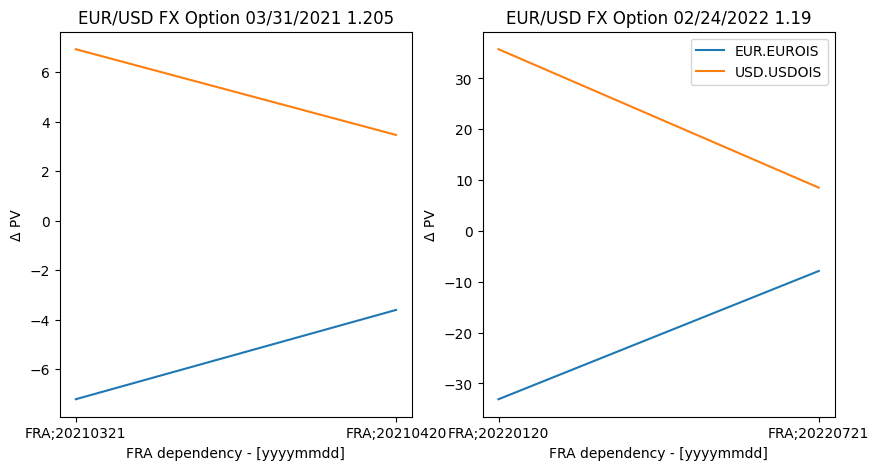

In [442]:
delta = '\u0394'
pd.set_option('display.max_colwidth', 200)
fig, axs = plt.subplots(1, 2, figsize = (10, 5))
val_df = run_valuation(base_date, portfolio_code, additional_keys=[lm.AggregateSpec(f"Risk/Rates/Delta/Central/PointWise", "Value")])
valuation = restools.parse_df_resultvalues(post_process(val_df))
display(valuation)

def plot_row(ax, row: pd.Series, *args: list[str]):
    for a in args:
        val_EUR: restools.Result1D = row["Risk/Rates/Delta/Central/PointWise"][f"Rates:{a}.{a}OIS"]
        ax.plot(val_EUR.values.keys(), val_EUR.values.values(), label = f"{a}.{a}OIS")
    ax.set_title(row["InstrumentName"])
    ax.set_xlabel(f"FRA dependency - [yyyymmdd]")
    ax.set_ylabel(f"{delta} PV")


for i, row in valuation[["ValuationDate", "InstrumentName", "Present Value", "Risk/Rates/Delta/Central/PointWise"]].iterrows():
    plot_row(axs[i], row, "EUR", "USD")
plt.legend()

## Rates Delta Ladder


,ValuationDate,InstrumentName,Quotes/FxRate/DomFgn,ClientInternal,Transaction/Id,Holding,Present Value,Delta,Portfolio,Risk/Rates/Difference/Ladder
0,2021-01-20 00:00:00+00:00,EUR/USD FX Option 03/31/2021 1.205,1.2106,EURUSDOption1DemoRisk,None,"1,000,000.0000","21,609.7001",0.5643,fxOptionRisk,"{'Rates:EUR.EUROIS': ({'-0.05': 5864.0586320796, '-0.025': 2820.1937987527, '-0.01': 1101.2282908524, '-0.005': 546.1436579111, '0.005': -537.2143772692, '0.01': -1065.5145717633, '0.025': -2597.1..."
1,2021-01-20 00:00:00+00:00,EUR/USD FX Option 02/24/2022 1.19,1.2106,EURUSDOption2DemoRisk,None,"-1,000,000.0000","-34,695.4263",-0.3754,fxOptionRisk,"{'Rates:EUR.EUROIS': ({'-0.05': 17001.1346279929, '-0.025': 9379.4069100774, '-0.01': 3961.1887025454, '-0.005': 2015.1132756809, '0.005': -2083.3232443546, '0.01': -4233.869453258, '0.025': -1107..."


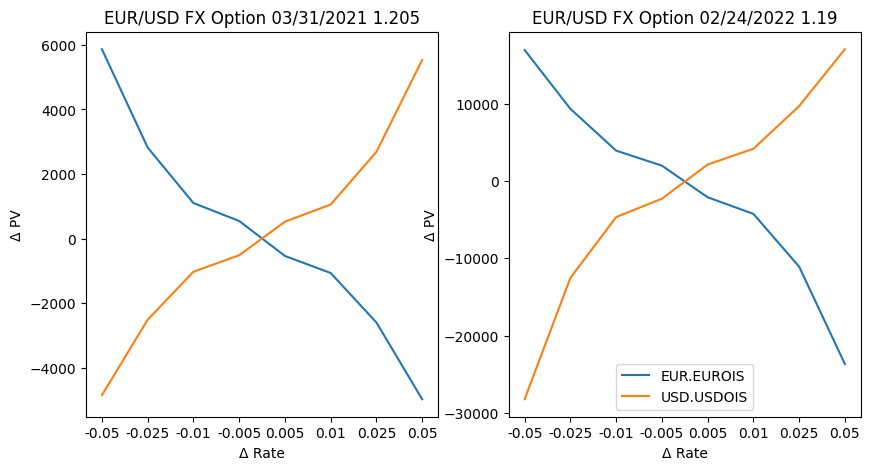

In [443]:
delta = '\u0394'
pd.set_option('display.max_colwidth', 200)
fig, axs = plt.subplots(1, 2, figsize = (10, 5))
val_df = run_valuation(base_date, portfolio_code, additional_keys=[lm.AggregateSpec(f"Risk/Rates/Difference/Ladder", "Value")])
valuation = restools.parse_df_resultvalues(post_process(val_df))
display(valuation)

def plot_row(ax, row: pd.Series, *args: list[str]):
    for a in args:
        val_EUR: restools.Result1D = row["Risk/Rates/Difference/Ladder"][f"Rates:{a}.{a}OIS"]
        ax.plot(val_EUR.values.keys(), val_EUR.values.values(), label = f"{a}.{a}OIS")
    ax.set_title(row["InstrumentName"])
    ax.set_xlabel(f"{delta} Rate")
    ax.set_ylabel(f"{delta} PV")


for i, row in valuation[["ValuationDate", "InstrumentName", "Present Value", "Risk/Rates/Difference/Ladder"]].iterrows():
    plot_row(axs[i], row, "EUR", "USD")
plt.legend()

## Fx vs Rate Ladder


,ValuationDate,InstrumentName,Quotes/FxRate/DomFgn,ClientInternal,Transaction/Id,Holding,Present Value,Delta,Portfolio,Risk/Fx/Ladder/Rates/Ladder/Difference
0,2021-01-20 00:00:00+00:00,EUR/USD FX Option 03/31/2021 1.205,1.2106,EURUSDOption1DemoRisk,None,"1,000,000.0000","21,609.7001",0.5643,fxOptionRisk,"{'Fx:EUR.USD;Rates:EUR.EUROIS': ({('-0.1', '-0.05'): 93884.6148494294, ('-0.1', '-0.025'): 89049.2182497694, ('-0.1', '-0.01'): 86173.6852851224, ('-0.1', '-0.005'): 85219.5158960814, ('-0.1', '0...."
1,2021-01-20 00:00:00+00:00,EUR/USD FX Option 02/24/2022 1.19,1.2106,EURUSDOption2DemoRisk,None,"-1,000,000.0000","-34,695.4263",-0.3754,fxOptionRisk,"{'Fx:EUR.USD;Rates:EUR.EUROIS': ({('-0.1', '-0.05'): 31720.90489364863, ('-0.1', '-0.025'): 29777.77016902513, ('-0.1', '-0.01'): 28214.78984438038, ('-0.1', '-0.005'): 27618.85855454668, ('-0.1',..."


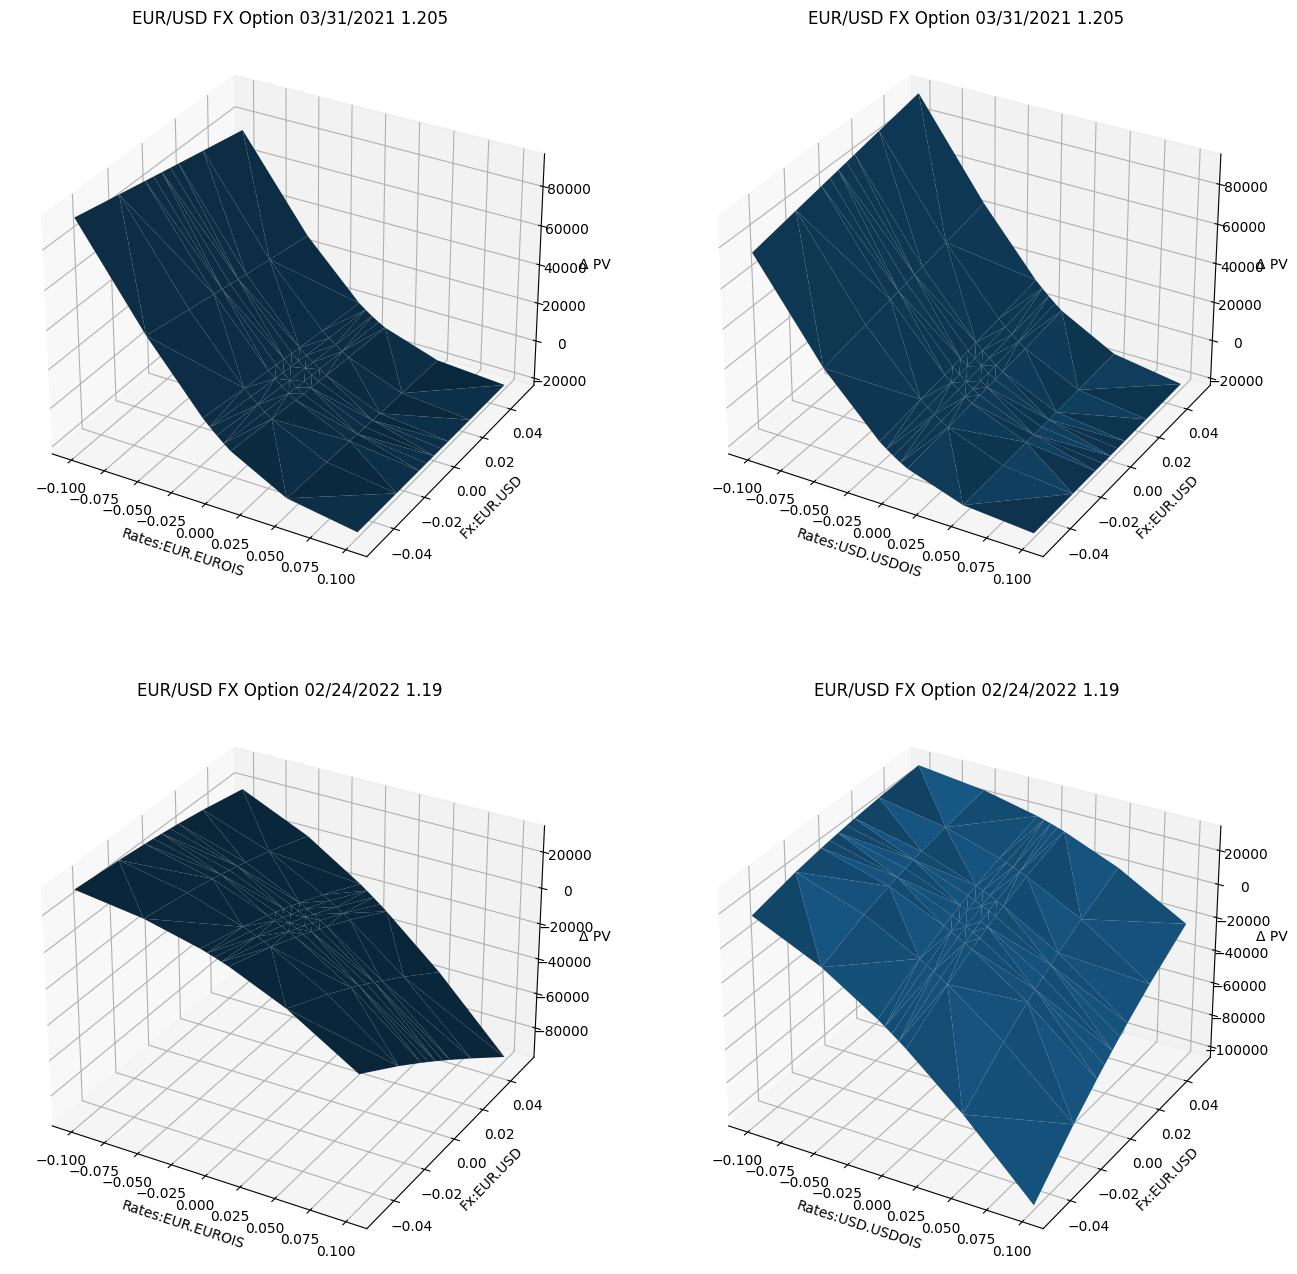

In [444]:
delta = '\u0394'
pd.set_option('display.max_colwidth', 200)
fig = plt.figure(figsize=(16,16))
val_df = run_valuation(base_date, portfolio_code, additional_keys=[lm.AggregateSpec(f"Risk/Fx/Ladder/Rates/Ladder/Difference", "Value")])
valuation = restools.parse_df_resultvalues(post_process(val_df))
display(valuation)

def plot_row(ax, row: pd.Series, *args: list[str]):

    val:restools.Result2D = row["Risk/Fx/Ladder/Rates/Ladder/Difference"][";".join(args)]
    xy_pair = val.result[0].keys()
    x = [t[0] for t in xy_pair]
    y = [t[1] for t in xy_pair]
    z = [t for t in val.result[0].values()]
    ax.set_xlabel(args[1])
    ax.set_ylabel(args[0])
    ax.set_zlabel(f"{delta} PV")
    ax.set_title(row["InstrumentName"])
    ax.plot_trisurf(x, y, z)


for i, row in valuation[["ValuationDate", "InstrumentName", "Present Value", "Risk/Fx/Ladder/Rates/Ladder/Difference"]].iterrows():
    ax = fig.add_subplot(2, 2, 2 * i + 1, projection="3d")
    plot_row(ax, row, "Fx:EUR.USD", "Rates:EUR.EUROIS")

    ax = fig.add_subplot(2, 2, 2 * i + 2, projection="3d")
    plot_row(ax, row, "Fx:EUR.USD", "Rates:USD.USDOIS")

# 7. Spot Ladder

This demonstrates how to produce a spot ladder to show the PV and Delta of the options as the underlying (FX Spot) changes. This is a standard report required by any risk manager looking at an option portfolio, and requires the risk engine to change the spot rate and revalue the portfolio multiple times. The methodology to do this is as follows:

Obtain and store the spot rate on the day we want to value the portfolio (so we can set the spot rate back to what it was originally). Next run a simple loop to generate the spot ladder, in the loop we:

a. Calculate the spot level on the ladder

b. Set this spot rate in the quote store in LUSID

c. Run a valuation and store the results

Finally we put the spot rate back to the original value (so that the normal 'market PV' is then obtained by the next user)

In [445]:
calculation_date = datetime(2021, 1, 23, tzinfo=pytz.utc)

The next section is the actual calculation of the spot ladder.

### Plotting

,ValuationDate,InstrumentName,Quotes/FxRate/DomFgn,ClientInternal,Holding,Present Value,Delta,Portfolio,Risk/Fx/Difference/Ladder
0,2021-01-23 00:00:00+00:00,EUR/USD FX Option 03/31/2021 1.205,1.2171,EURUSDOption1DemoRisk,"1,000,000.0000","24,256.4392",0.6117,fxOptionRisk,"{'Fx:EUR.USD': ({'-0.1': 86347.9031307791, '-0.05': 38467.6379080373, '-0.01': 6305.1826805333, '-0.005': 3048.8674187796, '0.005': -2835.4290835735, '0.01': -5453.9993297441, '0.05': -19016.46012..."
1,2021-01-23 00:00:00+00:00,EUR/USD FX Option 02/24/2022 1.19,1.2171,EURUSDOption2DemoRisk,"-1,000,000.0000","-32,357.7004",-0.3588,fxOptionRisk,"{'Fx:EUR.USD': ({'-0.1': 25399.11244213097, '-0.05': 16025.4079621507, '-0.01': 3798.1836479239, '-0.005': 1937.2414118393, '0.005': -2013.9057970319, '0.01': -4104.7102884677, '0.05': -23585.5876..."


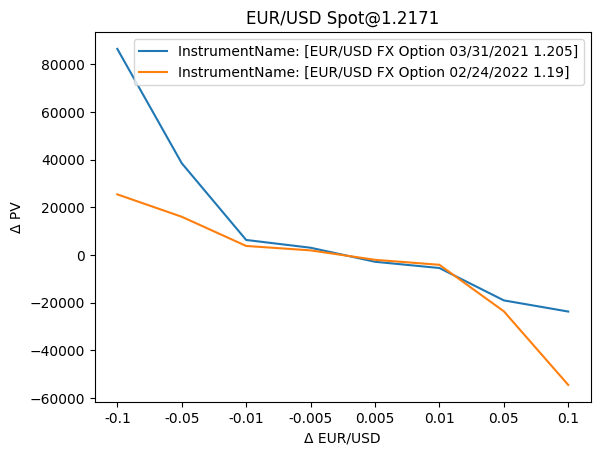

In [446]:
val_df = run_valuation(calculation_date, portfolio_code, additional_keys=[lm.AggregateSpec("Risk/Fx/Difference/Ladder", "Value")])
valuation = restools.parse_df_resultvalues(post_process(val_df))
display(valuation)

delta = '\u0394'
pd.set_option('display.max_colwidth', 200)
plot_vector(valuation, "Risk/Fx/Difference/Ladder", "InstrumentName")
plt.title(f"EUR/USD Spot@{valuation['Quotes/FxRate/DomFgn'][0]}")
plt.xlabel(f"{delta} EUR/USD")
plt.ylabel(f"{delta} PV")
plt.legend()

Displaying the PV results graphically for the portfolio

,ValuationDate,Quotes/FxRate/DomFgn,Sum(Present Value),Portfolio,Sum(Risk/Fx/Difference/Ladder)
0,2021-01-23 00:00:00+00:00,1.2171,"1,898.7387",fxOptionRisk,"{'Fx:EUR.USD': ({'-0.1': 111747.01557291007, '-0.05': 54493.045870188, '-0.01': 10103.3663284572, '-0.005': 4986.1088306189, '0.005': -4849.3348806054, '0.01': -9558.7096182118, '0.05': -42602.047..."


,ValuationDate,Sum(Present Value),Sum(Risk/Fx/Difference/Ladder)
0,2021-01-23 00:00:00+00:00,"1,898.7387","{'Fx:EUR.USD': ({'-0.1': 111747.01557291007, '-0.05': 54493.045870188, '-0.01': 10103.3663284572, '-0.005': 4986.1088306189, '0.005': -4849.3348806054, '0.01': -9558.7096182118, '0.05': -42602.047..."


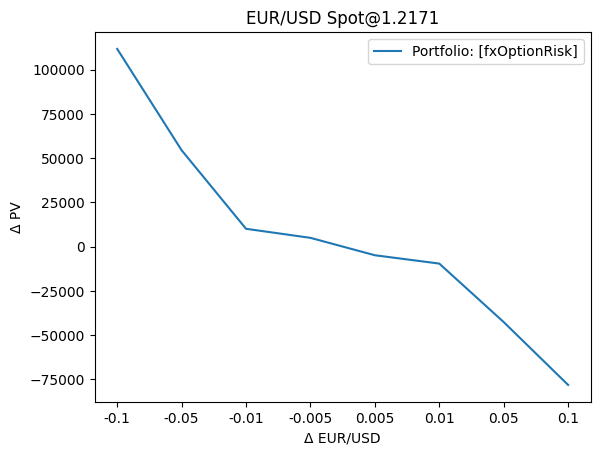

In [447]:
val_df = run_valuation(calculation_date, portfolio_code, group_by_portfolio=True, additional_keys=[lm.AggregateSpec("Risk/Fx/Difference/Ladder", "Sum")])
valuation = restools.parse_df_resultvalues(post_process(val_df))
display(valuation)
delta = '\u0394'
pd.set_option('display.max_colwidth', 200)
display(valuation[["ValuationDate", "Sum(Present Value)", "Sum(Risk/Fx/Difference/Ladder)"]]) 
plot_vector(valuation, "Sum(Risk/Fx/Difference/Ladder)", "Portfolio")
plt.title(f"EUR/USD Spot@{valuation['Quotes/FxRate/DomFgn'][0]}")
plt.xlabel(f"{delta} EUR/USD")
plt.ylabel(f"{delta} PV")
plt.legend()

# 8. Pointwise Vol Ladder

This demonstrates how to produce a .1Vol ladder to show the PV of the options as the points on the volatility surface are bumped. This is a standard report required by any risk manager looking at an option portfolio, and requires the risk engine to change the vol tenor values and revalue the portfolio multiple times.

,ValuationDate,InstrumentName,Quotes/FxRate/DomFgn,ClientInternal,Holding,Present Value,Delta,Portfolio,Risk/FxVol/Delta/Central/PointWise
0,2021-01-23 00:00:00+00:00,EUR/USD FX Option 03/31/2021 1.205,1.2171,EURUSDOption1DemoRisk,"1,000,000.0000","24,256.4392",0.6117,fxOptionRisk,"{'FxVol:EUR.USD.LN': ({('FXO;EURUSD;20210321', '1.2'): 7.28207092015, ('FXO;EURUSD;20210420', '1.2'): 3.64103547715, ('FXO;EURUSD;20210321', '1.215'): 3.64103547715, ('FXO;EURUSD;20210420', '1.215..."
1,2021-01-23 00:00:00+00:00,EUR/USD FX Option 02/24/2022 1.19,1.2171,EURUSDOption2DemoRisk,"-1,000,000.0000","-32,357.7004",-0.3588,fxOptionRisk,"{'FxVol:EUR.USD.LN': ({('FXO;EURUSD;20220120', '1.185'): -20.85957812, ('FXO;EURUSD;20220721', '1.185'): -4.96656625725, ('FXO;EURUSD;20220120', '1.2'): -10.42978912375, ('FXO;EURUSD;20220721', '1..."


2 1


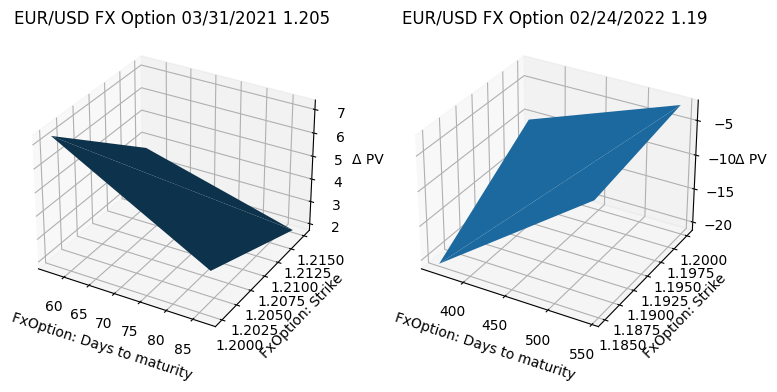

In [448]:
# Risk/FxVol/Delta/Central/PointWise: 
# Produces 2D result. 
# Calculation is for present value denoted V and variable x, dV/dx using central 2 point finite difference

val_df = run_valuation(calculation_date, portfolio_code, additional_keys=[lm.AggregateSpec("Risk/FxVol/Delta/Central/PointWise", "Value")])
valuation = restools.parse_df_resultvalues(post_process(val_df))
display(valuation)

delta = '\u0394'
pd.set_option('display.max_colwidth', 200)
plot_surface(
    valuation, 
    "Risk/FxVol/Delta/Central/PointWise", 
    "InstrumentName",
    xlabel="FxOption: Days to maturity",
    ylabel="FxOption: Strike",
    zlabel=f"{delta} PV", 
    coordinate_map = lambda row, x, y: [
        (datetime.strptime(x.split(";")[-1], "%Y%m%d").replace(tzinfo=pytz.UTC) - row["ValuationDate"]).days, 
        y
        ]
    )

# 9. Spot Pointwise Vol Ladder
This demonstrates how to produce a Spot.1Vol ladder to show the PV of the options as the points on the volatility surface are bumped. This is a standard report required by any risk manager looking at an option portfolio, and requires the risk engine to change the spot rate and the vol tenor values at the same time, revaluing the portfolio multiple times. The report is basically multiple .1Vol reports at calculated different spot rates, in practice the spot_rates are changed in an outer loop, with the vol tenors in an inner loop.

,ValuationDate,InstrumentName,Quotes/FxRate/DomFgn,ClientInternal,Holding,Present Value,Delta,Portfolio,Risk/FxVol/Delta/Central/PointWise
0,2021-01-23 00:00:00+00:00,EUR/USD FX Option 03/31/2021 1.205,1.2171,EURUSDOption1DemoRisk,"1,000,000.0000","24,256.4392",0.6117,fxOptionRisk,"{'FxVol:EUR.USD.LN': ({('FXO;EURUSD;20210321', '1.2'): 7.28207092015, ('FXO;EURUSD;20210420', '1.2'): 3.64103547715, ('FXO;EURUSD;20210321', '1.215'): 3.64103547715, ('FXO;EURUSD;20210420', '1.215..."
1,2021-01-23 00:00:00+00:00,EUR/USD FX Option 02/24/2022 1.19,1.2171,EURUSDOption2DemoRisk,"-1,000,000.0000","-32,357.7004",-0.3588,fxOptionRisk,"{'FxVol:EUR.USD.LN': ({('FXO;EURUSD;20220120', '1.185'): -20.85957812, ('FXO;EURUSD;20220721', '1.185'): -4.96656625725, ('FXO;EURUSD;20220120', '1.2'): -10.42978912375, ('FXO;EURUSD;20220721', '1..."


2 1


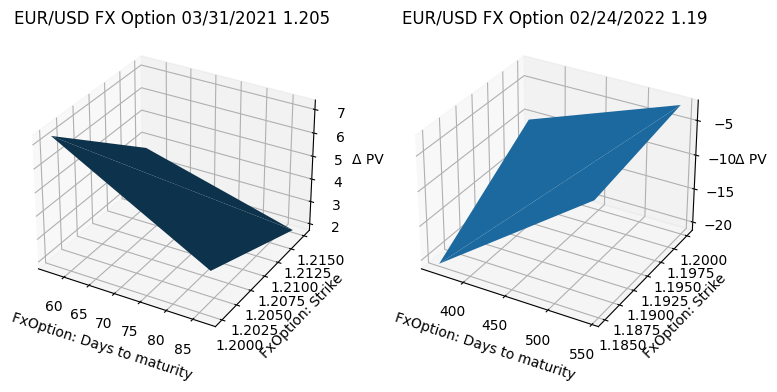

In [449]:
# This would require to create a 3D volume of values
# Since Pointwise bumping of FxVol surface creates a 2D surface of delta PV, also having a bumped spot-rate would create 3D result.

val_df = run_valuation(calculation_date, portfolio_code, additional_keys=[lm.AggregateSpec("Risk/FxVol/Delta/Central/PointWise", "Value")])
valuation = restools.parse_df_resultvalues(post_process(val_df))
display(valuation)

delta = '\u0394'
pd.set_option('display.max_colwidth', 200)
plot_surface(
    valuation, 
    "Risk/FxVol/Delta/Central/PointWise", 
    "InstrumentName",
    xlabel="FxOption: Days to maturity",
    ylabel="FxOption: Strike",
    zlabel=f"{delta} PV", 
    coordinate_map = lambda row, x, y: [
        (datetime.strptime(x.split(";")[-1], "%Y%m%d").replace(tzinfo=pytz.UTC) - row["ValuationDate"]).days, 
        y
        ]
    )

# 10. Spot-Vol Ladder

Note: This requires customizable bump size

This risk report is another type of spot-volatility report, but differs from the pointwise vol report as it bumps all of the volatility points on the surface in parallel. The report loops through changes to the volatility within a wider spot loop. Finally we remove the un-bumped base valuation from all points to see the delta impact of the bumps.

In [503]:
# Maybe? Risk/Fx/Parallel/FxVol/Parallel/Dy/Dx
# Would require similar to: Risk/Fx/Ladder/Rates/Ladder/Difference
# example: Risk/Fx/Ladder/FxVol/Parallel/Ladder/Difference

delta = '\u0394'
val_df = run_valuation(calculation_date, portfolio_code, group_by_portfolio=False, additional_keys=[lm.AggregateSpec("Risk/Fx/Parallel/FxVol/Parallel/Dy/Dx", "Value")])
valuation = restools.parse_df_resultvalues(post_process(val_df))
display(valuation)

,ValuationDate,InstrumentName,Quotes/FxRate/DomFgn,ClientInternal,Holding,Present Value,Delta,Portfolio,Risk/Fx/Parallel/FxVol/Parallel/Dy/Dx
0,2021-01-23 00:00:00+00:00,EUR/USD FX Option 03/31/2021 1.205,1.2171,EURUSDOption1DemoRisk,"1,000,000.0000","24,256.4392",0.6117,fxOptionRisk,"{'Fx:EUR.USD': (0.0, [])}"
1,2021-01-23 00:00:00+00:00,EUR/USD FX Option 02/24/2022 1.19,1.2171,EURUSDOption2DemoRisk,"-1,000,000.0000","-32,357.7004",-0.3588,fxOptionRisk,"{'Fx:EUR.USD': (-0.0862061989, [])}"


How would a trader use the above results? The results show that the portfolio makes money as the spot rate increases, and as volatility decreases.

# 11. Spot-Time Ladder

The last report we demonstrate is a spot-time report, this bumps spot but values the trades over multiple time points. LUSID has an in-built time ladder however this is not used here as we need to ensure the spot rate is bumped on the valuation date.

,ValuationDate,InstrumentName,Quotes/FxRate/DomFgn,ClientInternal,Holding,Present Value,Delta,Portfolio,Risk/Fx/Difference/Ladder
0,2021-01-23 00:00:00+00:00,EUR/USD FX Option 03/31/2021 1.205,1.2171,EURUSDOption1DemoRisk,"1,000,000.0000","24,256.4392",0.6117,fxOptionRisk,"{'Fx:EUR.USD': ({'-0.1': 86347.9031307791, '-0.05': 38467.6379080373, '-0.01': 6305.1826805333, '-0.005': 3048.8674187796, '0.005': -2835.4290835735, '0.01': -5453.9993297441, '0.05': -19016.46012..."
1,2021-01-23 00:00:00+00:00,EUR/USD FX Option 02/24/2022 1.19,1.2171,EURUSDOption2DemoRisk,"-1,000,000.0000","-32,357.7004",-0.3588,fxOptionRisk,"{'Fx:EUR.USD': ({'-0.1': 25399.11244213097, '-0.05': 16025.4079621507, '-0.01': 3798.1836479239, '-0.005': 1937.2414118393, '0.005': -2013.9057970319, '0.01': -4104.7102884677, '0.05': -23585.5876..."
4,2021-01-30 00:00:00+00:00,EUR/USD FX Option 03/31/2021 1.205,1.2136,EURUSDOption1DemoRisk,"1,000,000.0000","21,661.8427",0.5909,fxOptionRisk,"{'Fx:EUR.USD': ({'-0.1': 86364.030308216, '-0.05': 38237.3568282982, '-0.01': 6153.8005333556, '-0.005': 2965.3201752904, '0.005': -2736.5963012151, '0.01': -5242.0247099338, '0.05': -17632.212174..."
5,2021-01-30 00:00:00+00:00,EUR/USD FX Option 02/24/2022 1.19,1.2136,EURUSDOption2DemoRisk,"-1,000,000.0000","-33,108.5801",-0.3669,fxOptionRisk,"{'Fx:EUR.USD': ({'-0.1': 26008.32715339867, '-0.05': 16404.6200962578, '-0.01': 3885.3670117371, '-0.005': 1981.4817790668, '0.005': -2059.3888831898, '0.01': -4196.8599002098, '0.05': -24085.3323..."
8,2021-02-06 00:00:00+00:00,EUR/USD FX Option 03/31/2021 1.205,1.2046,EURUSDOption1DemoRisk,"1,000,000.0000","16,644.5045",0.5222,fxOptionRisk,"{'Fx:EUR.USD': ({'-0.1': 84722.2984066275, '-0.05': 36459.162057802, '-0.01': 5563.5082875279, '-0.005': 2657.6083448496, '0.005': -2407.9804923162, '0.01': -4568.906456071, '0.05': -14296.9698122..."
9,2021-02-06 00:00:00+00:00,EUR/USD FX Option 02/24/2022 1.19,1.2046,EURUSDOption2DemoRisk,"-1,000,000.0000","-35,802.7034",-0.3896,fxOptionRisk,"{'Fx:EUR.USD': ({'-0.1': 27969.07659695211, '-0.05': 17554.7568983012, '-0.01': 4137.4088574672, '-0.005': 2108.6351976045, '0.005': -2188.6221103511, '0.01': -4457.2150614947, '0.05': -25438.6253..."
12,2021-02-13 00:00:00+00:00,EUR/USD FX Option 03/31/2021 1.205,1.2120,EURUSDOption1DemoRisk,"1,000,000.0000","18,864.4302",0.5878,fxOptionRisk,"{'Fx:EUR.USD': ({'-0.1': 87953.9218984891, '-0.05': 39219.875163153, '-0.01': 6214.0191706902, '-0.005': 2980.0170057439, '0.005': -2718.4058466354, '0.01': -5172.2137447617, '0.05': -16313.096907..."
13,2021-02-13 00:00:00+00:00,EUR/USD FX Option 02/24/2022 1.19,1.2120,EURUSDOption2DemoRisk,"-1,000,000.0000","-32,828.9335",-0.3697,fxOptionRisk,"{'Fx:EUR.USD': ({'-0.1': 25986.73503959396, '-0.05': 16454.4404891347, '-0.01': 3907.7163686484, '-0.005': 1993.4670922457, '0.005': -2072.9981908547, '0.01': -4225.697272372, '0.05': -24291.15913..."
16,2021-02-20 00:00:00+00:00,EUR/USD FX Option 03/31/2021 1.205,1.2119,EURUSDOption1DemoRisk,"1,000,000.0000","17,677.4466",0.5932,fxOptionRisk,"{'Fx:EUR.USD': ({'-0.1': 89059.9941463212, '-0.05': 40044.234887257, '-0.01': 6320.1273339262, '-0.005': 3023.4876606296, '0.005': -2740.3612151606, '0.01': -5193.4984522114, '0.05': -15749.150210..."
17,2021-02-20 00:00:00+00:00,EUR/USD FX Option 02/24/2022 1.19,1.2119,EURUSDOption2DemoRisk,"-1,000,000.0000","-32,449.1432",-0.3693,fxOptionRisk,"{'Fx:EUR.USD': ({'-0.1': 25806.57082437478, '-0.05': 16383.097637382, '-0.01': 3898.4204869147, '-0.005': 1989.1721218345, '0.005': -2069.4269684047, '0.01': -4219.2923581083, '0.05': -24288.96897..."


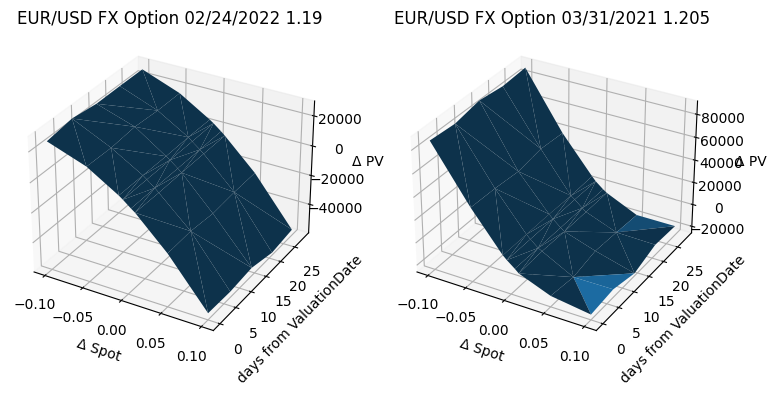

In [521]:
delta = '\u0394'
val_df = run_valuation([calculation_date + timedelta(days = i * 7) for i in range(5)], portfolio_code, group_by_portfolio=False, additional_keys=[lm.AggregateSpec("Risk/Fx/Difference/Ladder", "Value")])
valuation = restools.parse_df_resultvalues(post_process(val_df))
display(valuation)

fig = plt.figure(figsize =(14, 9))
n = len(valuation) # num rows
m: int = len(valuation["InstrumentName"].unique()) # num columns

# plotting by grouping on InstrumentName
for i, (k, df) in enumerate(valuation.groupby(by="InstrumentName")):

    curves: list[restools.Result1D] = [list(x.values())[0] for x in df["Risk/Fx/Difference/Ladder"].values]

    x: np.ndarray = np.array([[float(x) for x in crv.values.keys()] for crv in curves]).ravel() # np.ndarray[float]
    y: np.ndarray = [(x - calculation_date).days for x in df["ValuationDate"]] * len(curves[0].values) # np.ndarray[datetime]
    z: list[float] = np.array([list(crv.values.values()) for crv in curves]).ravel() # np.ndarray[restools.Result0D]

    ax = fig.add_subplot(1, 1 + m, i + 1, projection="3d")
    ax.plot_trisurf(x, y, z)
    ax.set_title(f"{k}")
    ax.set_xlabel(f"{delta} Spot")
    ax.set_ylabel("days from ValuationDate")
    ax.set_zlabel(f"{delta} PV")

    pass

How would a trader use the above results? The report is showing how much the portfolio will be worth on different dates under different spot rate conditions. If the report was run into the future, then a trader would understand the impact of theta on their portfolio. The way the report is written it can be run historically using the spot rates in the store, and these are bumped by the same amount on each day. There is however only one set of discount factors and one volatility surface, and as time progresses both these peices of market data will change significantly (especially when the UK government has special fiscal events).